In [2]:
# Instalación de librerías (ejecutar solo si es necesario)
!pip install scikit-learn pandas matplotlib seaborn openpyxl

In [3]:
# Importaciones necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)

# Configuración de gráficos
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [4]:
# Carga de datos desde SQLite
db_path = '../data/airbnb.db'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM listings", conn)
conn.close()

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")
df.head()

Dataset cargado: 26401 registros, 77 columnas


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,categoria_precio
0,35797,https://www.airbnb.com/rooms/35797,20250625031918,2025-06-26 00:00:00,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,153786,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Premium
1,44616,https://www.airbnb.com/rooms/44616,20250625031918,2025-07-01 00:00:00,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,None,https://a0.muscache.com/pictures/251410/ec75fe...,196253,...,2025-01-01 00:00:00,4.59,4.56,4.70,4.87,4.78,4.98,4.47,0.39,Premium
2,56074,https://www.airbnb.com/rooms/56074,20250625031918,2025-07-01 00:00:00,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,265650,...,2025-02-27 00:00:00,4.87,4.95,4.88,4.98,4.94,4.76,4.79,0.48,Medio
3,67703,https://www.airbnb.com/rooms/67703,20250625031918,2025-07-01 00:00:00,city scrape,"2 bedroom apt. deco bldg, Condesa","Comfortably furnished, sunny, 2 bedroom apt., ...",None,https://a0.muscache.com/pictures/3281720/6f078...,334451,...,2024-10-30 00:00:00,4.90,4.82,4.76,4.94,4.92,4.98,4.92,0.30,Alto
4,70644,https://www.airbnb.com/rooms/70644,20250625031918,2025-07-01 00:00:00,city scrape,Beautiful light Studio Coyoacan- full equipped !,COYOACAN designer studio quiet & safe! well eq...,Coyoacan is a beautiful neighborhood famous fo...,https://a0.muscache.com/pictures/f397d2da-d045...,212109,...,2024-12-28 00:00:00,4.92,4.91,4.96,4.96,4.98,4.96,4.92,0.81,Alto


=== ANÁLISIS DE NUMBER_OF_REVIEWS ===
count    26401.000000
mean        52.582326
std         82.711741
min          0.000000
25%          4.000000
50%         21.000000
75%         67.000000
max       1342.000000
Name: number_of_reviews, dtype: float64


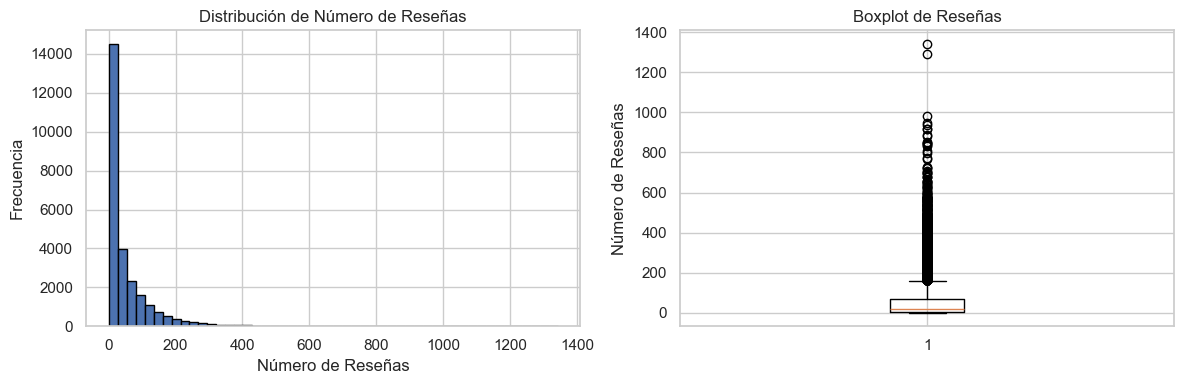


Reseñas mínimas: 0
Reseñas máximas: 1342
Reseñas promedio: 52.58
Reseñas mediana: 21.00


In [5]:
# Exploración de la variable objetivo: number_of_reviews
print("=== ANÁLISIS DE NUMBER_OF_REVIEWS ===")
print(df['number_of_reviews'].describe())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['number_of_reviews'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.title('Distribución de Número de Reseñas')

plt.subplot(1, 2, 2)
plt.boxplot(df['number_of_reviews'].dropna())
plt.ylabel('Número de Reseñas')
plt.title('Boxplot de Reseñas')

plt.tight_layout()
plt.show()

print(f"\nReseñas mínimas: {df['number_of_reviews'].min()}")
print(f"Reseñas máximas: {df['number_of_reviews'].max()}")
print(f"Reseñas promedio: {df['number_of_reviews'].mean():.2f}")
print(f"Reseñas mediana: {df['number_of_reviews'].median():.2f}")


=== CREACIÓN DE CATEGORÍAS DE DEMANDA ===
Percentil 33: 7 reseñas
Percentil 66: 45 reseñas

Distribución de categorías:
categoria_demanda
Baja     8906
Alta     8864
Media    8631
Name: count, dtype: int64

Proporción:
categoria_demanda
Baja     0.337336
Alta     0.335745
Media    0.326919
Name: proportion, dtype: float64


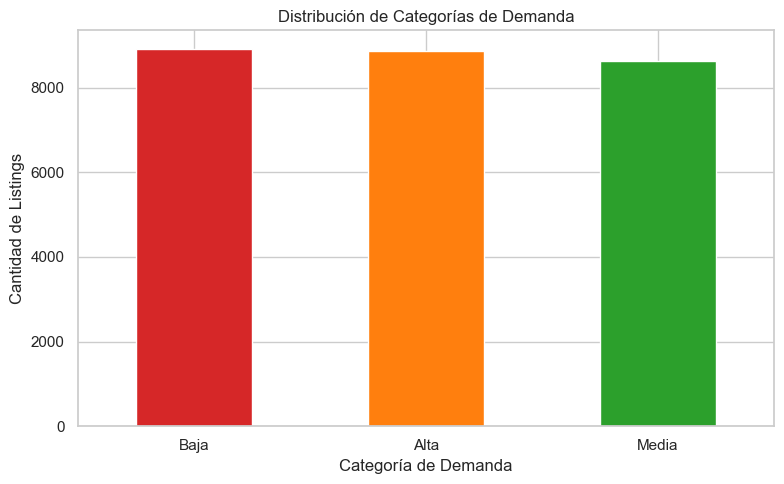

In [6]:
# Crear categorías de demanda basadas en percentiles
print("\n=== CREACIÓN DE CATEGORÍAS DE DEMANDA ===")

# Calcular percentiles
p33 = df['number_of_reviews'].quantile(0.33)
p66 = df['number_of_reviews'].quantile(0.66)

print(f"Percentil 33: {p33:.0f} reseñas")
print(f"Percentil 66: {p66:.0f} reseñas")

# Crear variable categórica
def categorizar_demanda(reviews):
    if pd.isna(reviews):
        return None
    elif reviews <= p33:
        return 'Baja'
    elif reviews <= p66:
        return 'Media'
    else:
        return 'Alta'

df['categoria_demanda'] = df['number_of_reviews'].apply(categorizar_demanda)

# Distribución de categorías
print("\nDistribución de categorías:")
print(df['categoria_demanda'].value_counts())
print("\nProporción:")
print(df['categoria_demanda'].value_counts(normalize=True))

# Visualización
plt.figure(figsize=(8, 5))
df['categoria_demanda'].value_counts().plot(kind='bar', color=['#d62728', '#ff7f0e', '#2ca02c'])
plt.xlabel('Categoría de Demanda')
plt.ylabel('Cantidad de Listings')
plt.title('Distribución de Categorías de Demanda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
# Selección de features
features_numericas = [
    'price',
    'accommodates', 
    'bedrooms', 
    'bathrooms',
    'availability_365',
    'minimum_nights'
]

features_categoricas = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed',
    'host_is_superhost',
    'instant_bookable'
]

target = 'categoria_demanda'

# Crear dataset de trabajo
columnas_necesarias = features_numericas + features_categoricas + [target]
df_trabajo = df[columnas_necesarias].copy()

print(f"Dataset de trabajo: {df_trabajo.shape}")
print(f"\nValores nulos por columna:")
print(df_trabajo.isnull().sum())

Dataset de trabajo: (26401, 12)

Valores nulos por columna:
price                     3274
accommodates                 0
bedrooms                   924
bathrooms                 3281
availability_365             0
minimum_nights               0
property_type                0
room_type                    0
neighbourhood_cleansed       0
host_is_superhost         1359
instant_bookable             0
categoria_demanda            0
dtype: int64


In [8]:
# Limpieza de datos
print("\n=== LIMPIEZA DE DATOS ===")

# Eliminar filas con nulos en columnas clave
df_trabajo = df_trabajo.dropna(subset=['categoria_demanda', 'price', 'bedrooms', 'bathrooms'])
print(f"Después de eliminar nulos: {len(df_trabajo)} registros")

# Filtrar precios extremos
percentil_99 = df_trabajo['price'].quantile(0.99)
df_trabajo = df_trabajo[df_trabajo['price'] <= percentil_99]
df_trabajo = df_trabajo[df_trabajo['price'] >= 100]
print(f"Después de filtrar outliers de precio: {len(df_trabajo)} registros")

# Rellenar nulos en numéricas con mediana
for col in features_numericas:
    if df_trabajo[col].isnull().sum() > 0:
        mediana = df_trabajo[col].median()
        df_trabajo[col].fillna(mediana, inplace=True)

# Rellenar nulos en categóricas con 'Unknown'
for col in features_categoricas:
    if df_trabajo[col].isnull().sum() > 0:
        df_trabajo[col].fillna('Unknown', inplace=True)

print(f"\nDataset limpio final: {df_trabajo.shape}")
print(f"\nDistribución final de categorías:")
print(df_trabajo['categoria_demanda'].value_counts())


=== LIMPIEZA DE DATOS ===
Después de eliminar nulos: 23039 registros
Después de filtrar outliers de precio: 22802 registros

Dataset limpio final: (22802, 12)

Distribución final de categorías:
categoria_demanda
Alta     8304
Media    7638
Baja     6860
Name: count, dtype: int64


In [9]:
# Encoding de variables categóricas
print("\n=== ENCODING DE VARIABLES CATEGÓRICAS ===")

# Agrupar property_type con pocas ocurrencias
property_counts = df_trabajo['property_type'].value_counts()
property_top = property_counts[property_counts >= 100].index
df_trabajo['property_type'] = df_trabajo['property_type'].apply(
    lambda x: x if x in property_top else 'Other'
)

# Convertir booleanas a numérico
for col in ['host_is_superhost', 'instant_bookable']:
    if col in df_trabajo.columns:
        df_trabajo[col] = df_trabajo[col].map(
            {True: 1, 'True': 1, 't': 1, 'VERDADERO': 1, 
             False: 0, 'False': 0, 'f': 0, 'FALSO': 0}
        ).fillna(0).astype(int)

# One-Hot Encoding
df_encoded = pd.get_dummies(
    df_trabajo, 
    columns=['property_type', 'room_type', 'neighbourhood_cleansed'],
    drop_first=True
)

print(f"Dataset después de encoding: {df_encoded.shape}")
print(f"Total de features: {df_encoded.shape[1] - 1}")


=== ENCODING DE VARIABLES CATEGÓRICAS ===
Dataset después de encoding: (22802, 42)
Total de features: 41


In [10]:
# Separar features y target
X = df_encoded.drop('categoria_demanda', axis=1)
y = df_encoded['categoria_demanda']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== DIVISIÓN DEL DATASET ===")
print(f"Entrenamiento: {X_train.shape[0]} registros")
print(f"Prueba: {X_test.shape[0]} registros")
print(f"Features: {X_train.shape[1]}")
print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts())
print(f"\nDistribución en prueba:")
print(y_test.value_counts())


=== DIVISIÓN DEL DATASET ===
Entrenamiento: 18241 registros
Prueba: 4561 registros
Features: 41

Distribución en entrenamiento:
categoria_demanda
Alta     6643
Media    6110
Baja     5488
Name: count, dtype: int64

Distribución en prueba:
categoria_demanda
Alta     1661
Media    1528
Baja     1372
Name: count, dtype: int64


In [11]:
# Entrenamiento del modelo
print("\n=== ENTRENAMIENTO DEL MODELO ===")
print("Modelo: Logistic Regression (multi-class)")
print("Entrenando...")

lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs'
)

lr.fit(X_train, y_train)
print("✓ Modelo entrenado")

# Predicciones
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("✓ Predicciones generadas")


=== ENTRENAMIENTO DEL MODELO ===
Modelo: Logistic Regression (multi-class)
Entrenando...
✓ Modelo entrenado
✓ Predicciones generadas


In [12]:
# Evaluación del modelo
print("\n=== MÉTRICAS DE EVALUACIÓN ===")

# Métricas en entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, average='macro')
rec_train = recall_score(y_train, y_pred_train, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')

print("\nEntrenamiento:")
print(f"  Accuracy:  {acc_train:.4f}")
print(f"  Precision: {prec_train:.4f}")
print(f"  Recall:    {rec_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

# Métricas en prueba
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, average='macro')
rec_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

print("\nPrueba:")
print(f"  Accuracy:  {acc_test:.4f}")
print(f"  Precision: {prec_test:.4f}")
print(f"  Recall:    {rec_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

# Reporte de clasificación detallado
print("\n=== REPORTE DE CLASIFICACIÓN (TEST) ===")
print(classification_report(y_test, y_pred_test))


=== MÉTRICAS DE EVALUACIÓN ===

Entrenamiento:
  Accuracy:  0.4981
  Precision: 0.4754
  Recall:    0.4992
  F1-Score:  0.4624

Prueba:
  Accuracy:  0.4898
  Precision: 0.4685
  Recall:    0.4913
  F1-Score:  0.4560

=== REPORTE DE CLASIFICACIÓN (TEST) ===
              precision    recall  f1-score   support

        Alta       0.51      0.65      0.57      1661
        Baja       0.49      0.67      0.57      1372
       Media       0.40      0.16      0.23      1528

    accuracy                           0.49      4561
   macro avg       0.47      0.49      0.46      4561
weighted avg       0.47      0.49      0.46      4561



<Figure size 800x600 with 0 Axes>

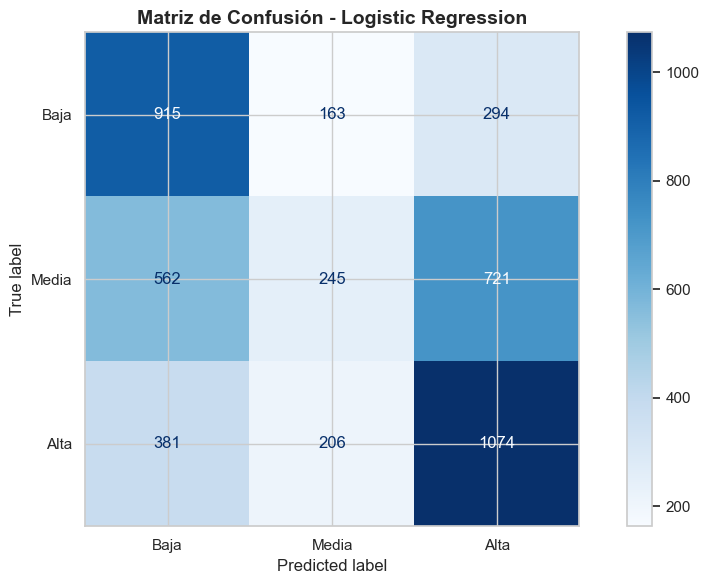


Interpretación de la matriz:
- Diagonal principal: predicciones correctas
- Fuera de diagonal: errores de clasificación


In [13]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, labels=['Baja', 'Media', 'Alta'])

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Baja', 'Media', 'Alta'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Logistic Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretación de la matriz:")
print("- Diagonal principal: predicciones correctas")
print("- Fuera de diagonal: errores de clasificación")

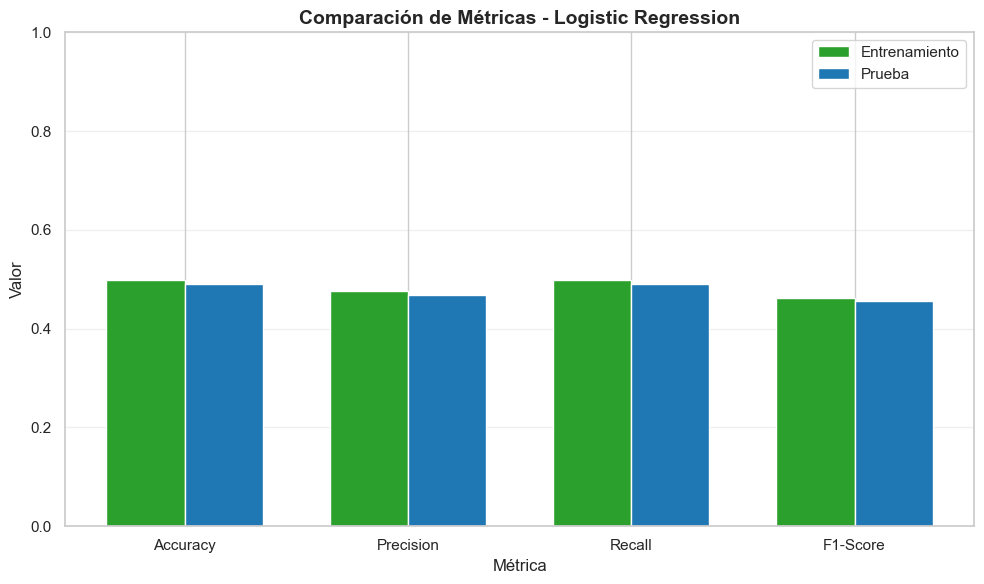

In [14]:
# Comparación visual de métricas
metricas = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Entrenamiento': [acc_train, prec_train, rec_train, f1_train],
    'Prueba': [acc_test, prec_test, rec_test, f1_test]
})

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas))
width = 0.35

bars1 = ax.bar(x - width/2, metricas['Entrenamiento'], width, label='Entrenamiento', color='#2ca02c')
bars2 = ax.bar(x + width/2, metricas['Prueba'], width, label='Prueba', color='#1f77b4')

ax.set_xlabel('Métrica', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Comparación de Métricas - Logistic Regression', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Métrica'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()